###Imports


In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###Loading the images

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/Anime/Style'

/content/drive/MyDrive/Colab Notebooks/Anime/Style


In [5]:
%ls


00000_0058.png  00414_0040.png  00822_0019.png  01212_0042.png  01649_0020.png
00000_0062.png  00415_0041.png  00822_0092.png  01212_0070.png  01650_0017.png
00001_0003.png  00415_0049.png  00823_0083.png  01213_0018.png  01651_0094.png
00001_0014.png  00416_0020.png  00824_0009.png  01213_0030.png  01652_0058.png
00002_0005.png  00416_0055.png  00825_0037.png  01214_0004.png  01653_0070.png
00002_0063.png  00417_0006.png  00826_0065.png  01214_0056.png  01654_0086.png
00003_0073.png  00417_0087.png  00831_0004.png  01215_0008.png  01655_0040.png
00003_0083.png  00418_0023.png  00831_0006.png  01215_0014.png  01656_0048.png
00004_0058.png  00418_0031.png  00832_0053.png  01216_0078.png  01657_0045.png
00004_0074.png  00419_0004.png  00832_0073.png  01216_0082.png  01658_0083.png
00005_0007.png  00419_0036.png  00833_0057.png  01217_0027.png  01659_0089.png
00005_0077.png  00420_0024.png  00833_0083.png  01217_0078.png  01660_0048.png
00006_0037.png  00420_0041.png  00834_0029.png  0121

How many images in the folder?

In [6]:
import os

# Set the path to the directory containing your images
directory = '/content/drive/MyDrive/Colab Notebooks/Anime/Style'

# Get a list of all the image filenames in the directory
filenames = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

# Print the total number of images in the directory
print(f'Total number of images: {len(filenames)}')


Total number of images: 3599


###Splitting the data into train, test and val sets.

In [ ]:
import random
import shutil

# Set the path to the original image directory
original_dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Anime/Style'

# Set the path to the directory where you want to store the training, validation, and testing data
base_dir = '/content/drive/MyDrive/Colab Notebooks/Anime/Style_split'
os.makedirs(base_dir, exist_ok=True)

# Set the paths to the training, validation, and testing directories
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Set the percentage of data to use for training, validation, and testing
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Get a list of all the image filenames in the original directory
filenames = os.listdir(original_dataset_dir)
random.shuffle(filenames)

# Calculate the number of images for each set based on the desired split
num_train = int(len(filenames) * train_split)
num_val = int(len(filenames) * val_split)
num_test = int(len(filenames) * test_split)

# Copy the images into the training directory
for i in range(num_train):
    src = os.path.join(original_dataset_dir, filenames[i])
    dst = os.path.join(train_dir, filenames[i])
    shutil.copyfile(src, dst)

# Copy the images into the validation directory
for i in range(num_train, num_train + num_val):
    src = os.path.join(original_dataset_dir, filenames[i])
    dst = os.path.join(val_dir, filenames[i])
    shutil.copyfile(src, dst)

# Copy the images into the testing directory
for i in range(num_train + num_val, len(filenames)):
    src = os.path.join(original_dataset_dir, filenames[i])
    dst = os.path.join(test_dir, filenames[i])
    shutil.copyfile(src, dst)


In [ ]:
#!unzip animeSubset.zip


unzip:  cannot find or open animeSubset.zip, animeSubset.zip.zip or animeSubset.zip.ZIP.


In [ ]:
# style_img = image_loader("./data/images/neural-style/brownhairanime.jpg")
# #content_img = image_loader("./data/images/neural-style/kiera.jpg")
# style_img.size()
# #content_img.size()

In [8]:
#from torchvision import datasets

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# style_transform = transforms.Compose([
#     transforms.Resize(imsize),
#     transforms.CenterCrop(imsize),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# style_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Anime', transform=style_transform)

# # Create a data loader for the style images
# style_loader = torch.utils.data.DataLoader(style_dataset, batch_size=1, shuffle=False)


# import torch.nn.functional as F

style_image_size = (512, 760)
content_image_size = (512, 767)

# Load style and content images
style_img = image_loader("/content/data/images/neural-style/brownhairanime.jpg")
# Load style and content images
#style_img, _ = next(iter(style_loader))
#style_img = style_img.to(device)
content_img = image_loader('/content/data/images/neural-style/kiera.jpg')

# Resize content image to match style image
#content_img = F.interpolate(content_img, size=style_img.size()[2:], mode='bilinear', align_corners=False)

# # Resize content image to match style image
content_img = F.interpolate(content_img, size=style_image_size, mode='bilinear', align_corners=False)

#style_img = image_loader("./data/images/neural-style/picasso.jpg")
#content_img = image_loader("./data/images/neural-style/downloadog.png")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

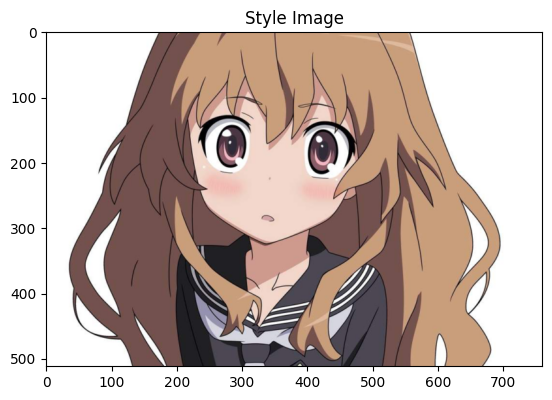

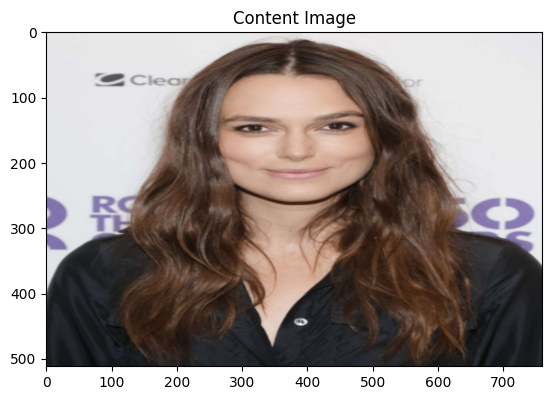

In [9]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

##Loss Functions
###Content Loss

In [11]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

###Style Loss

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [13]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

##Import models

In [14]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:35<00:00, 16.1MB/s]


In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [16]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Selecting the input image.

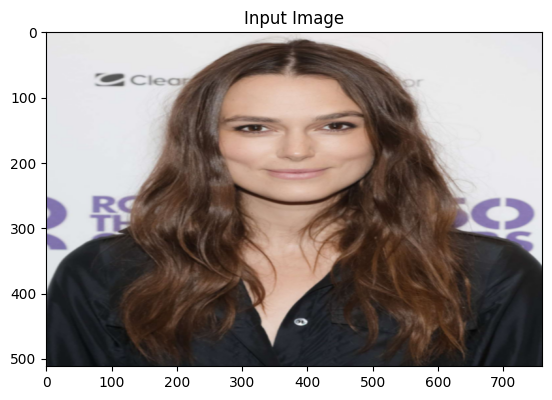

In [17]:
import matplotlib.pyplot as plt
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
#plt.imshow(input_img.cpu().squeeze(0).permute(1, 2, 0))
#plt.title('Input Image')
#plt.show()
imshow(input_img, title='Input Image')


##Gradient Descent

In [18]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [19]:
# import os
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms

# def run_style_transfer_on_dataset(cnn, normalization_mean, normalization_std,
#                                    style_img, num_steps=300,
#                                    style_weight=1000000, content_weight=1):
#     """Run the style transfer on a dataset."""
#     print('Building the style transfer model..')
#     model, style_losses, content_losses = get_style_model_and_losses(cnn,
#         normalization_mean, normalization_std, style_img)

#     # We want to optimize the input and not the model parameters so we
#     # update all the requires_grad fields accordingly
#     input_img = torch.randn(style_img.data.size(), device=style_img.device)
#     input_img.requires_grad_(True)
#     model.requires_grad_(False)

#     optimizer = get_input_optimizer(input_img)

#     print('Loading the dataset..')
#     dataset = datasets.ImageFolder(root='style_images', transform=transforms.Compose([
#                                transforms.Resize(256),
#                                transforms.CenterCrop(256),
#                                transforms.ToTensor(),
#                                transforms.Normalize(mean=normalization_mean, std=normalization_std)
#                            ]))
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

#     print('Optimizing..')
#     run = [0]
#     for epoch in range(num_steps):
#         for i, (content_img, _) in enumerate(dataloader):
#             content_img = content_img.to(style_img.device)
#             model(input_img)

#             style_score = 0
#             content_score = 0

#             for sl in style_losses:
#                 style_score += sl.loss
#             for cl in content_losses:
#                 content_score += cl.loss

#             style_score *= style_weight
#             content_score *= content_weight

#             loss = style_score + content_score
#             loss.backward()

#             optimizer.step()
#             optimizer.zero_grad()

#             run[0] += 1
#             if run[0] % 50 == 0:
#                 print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_steps, i+1, len(dataloader), loss.item()))

#     # a last correction...
#     with torch.no_grad():
#         input_img.clamp_(0, 1)

#     return input_img


In [20]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

##Running the algorithm

In [21]:
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img)

# output = output.cpu().detach().numpy() # move tensor to CPU and convert to numpy array
# plt.figure()
# plt.imshow(output)
# plt.show()


Building the style transfer model..


<ipython-input-15-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 165.747437 Content Loss: 12.897893

run [100]:
Style Loss : 49.944038 Content Loss: 13.610229

run [150]:
Style Loss : 26.313885 Content Loss: 13.892244

run [200]:
Style Loss : 16.221411 Content Loss: 14.008008

run [250]:
Style Loss : 11.666837 Content Loss: 14.082373

run [300]:
Style Loss : 8.406334 Content Loss: 14.161051



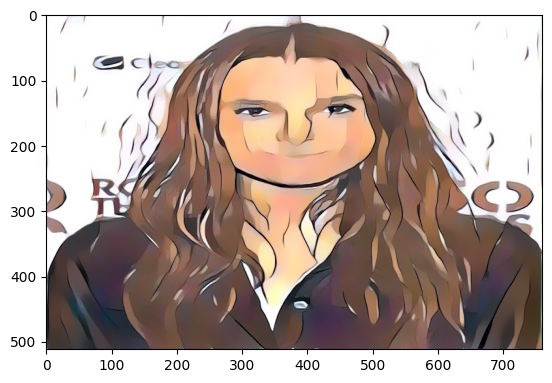

In [22]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output)

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()